# Setup Notebook

In [1]:
# import standard libraries
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [3]:
# install weight and biases library
!pip install wandb > /dev/null
import wandb

In [4]:
import sys, os

# setup repo
if os.path.exists('./dl-computer-vision'):
    !rm -r dl-computer-vision > /dev/null
!git clone https://github.com/simonamtoft/dl-computer-vision.git > /dev/null
sys.path.append('dl-computer-vision')

import models as m
import helpers as h
import data as d

Cloning into 'dl-computer-vision'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 253 (delta 122), reused 192 (delta 67), pack-reused 0
Receiving objects: 100% (253/253), 42.19 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [5]:
# Define name of project on weight and biases site
project_name = "project-1-2"

In [6]:
# Download data
import gdown
if not os.path.exists('./SVHN'):
    url = 'https://drive.google.com/uc?id=15UaE8bUpVBQPvE-y2Vb4XhxM-3mZWcC5'
    gdown.download(url, './SVHN.zip', quiet=True)
    !unzip ./SVHN.zip > /dev/null

# define path to SVHN data in your drive
path_to_data = "/content/SVHN"

# Project 1.2: Object Detection

In [7]:
# login to weight and biases
!wandb login

wandb: Currently logged in as: simonamtoft (use `wandb login --relogin` to force relogin)


In [8]:
config = {
    'epochs': 15,
    'batch_size': 64,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'conv_dim': [
        [16, 5],
        [16, 5], 
        [16, 3],
        [32, 3],
        [400, 3],
        [400, 1],
    ],
    'maxpool_idx': [2, 3],
    'batch_norm': False,
    'step_lr': [True, 1, 0.8],
    'reduce_size': 2,
}

## Load Evaluation and Train Data

In [9]:
# Define data transforms
svhn_train_transform = transforms.Compose([
  transforms.ToTensor()
])
svhn_test_transform = transforms.Compose([
  transforms.ToTensor()
])

In [10]:
# Download SVHN datasets 
svhn_trainset = datasets.SVHN(
    "./data", 
    split="train", 
    transform=svhn_train_transform, 
    download=True
)
svhn_valset = datasets.SVHN(
    "./data", 
    split="test", 
    transform=svhn_test_transform, 
    download=True
)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [11]:
# get 'corners' data
reduce_size = config['reduce_size'] 
corner_trainset = d.SVHNCorners(
    train=True, 
    transform=transforms.ToTensor(), 
    data_path=path_to_data
)
corner_trainset, _ = torch.utils.data.random_split(
    corner_trainset, 
    [len(corner_trainset) // reduce_size, 
     len(corner_trainset) - len(corner_trainset) // reduce_size]
)

corner_valset = d.SVHNCorners(
    train=False, 
    transform=transforms.ToTensor(), 
    data_path=path_to_data
)
corner_valset, _ = torch.utils.data.random_split(
    corner_valset, 
    [len(corner_valset) // reduce_size, 
     len(corner_valset) - len(corner_valset) // reduce_size]
)

In [12]:
# Concat datasets and setup loaders
trainset = ConcatDataset([svhn_trainset, corner_trainset])
valset = ConcatDataset([svhn_valset, corner_valset])

# get size
n_train = len(trainset)
n_val = len(valset)

In [13]:
# Get data loaders
train_loader = DataLoader(
    trainset, batch_size=config["batch_size"], shuffle=True, num_workers=2
)
val_loader = DataLoader(
    valset, batch_size=config["batch_size"], shuffle=False, num_workers=2
)

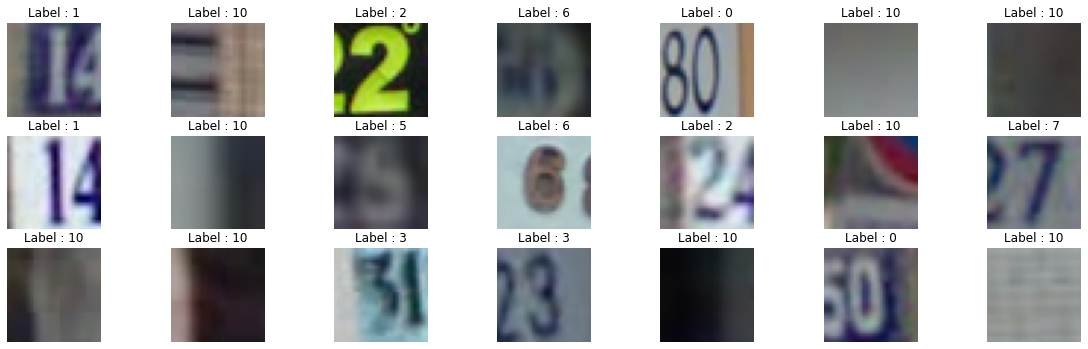

In [14]:
# Display some of the training data
images, labels = next(iter(train_loader))
plt.figure(figsize=(20, 10))

for i in range(21):
    plt.subplot(5, 7, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(f'Label : {labels[i]}')
    plt.axis('off')

## Load Test Data

In [15]:
# load the data
testset = d.SVHNReal(
    train=False,
    data_path=path_to_data,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2
)
# convert the data to a list such that it can be used for plotting
real_data_list = list(testset) 

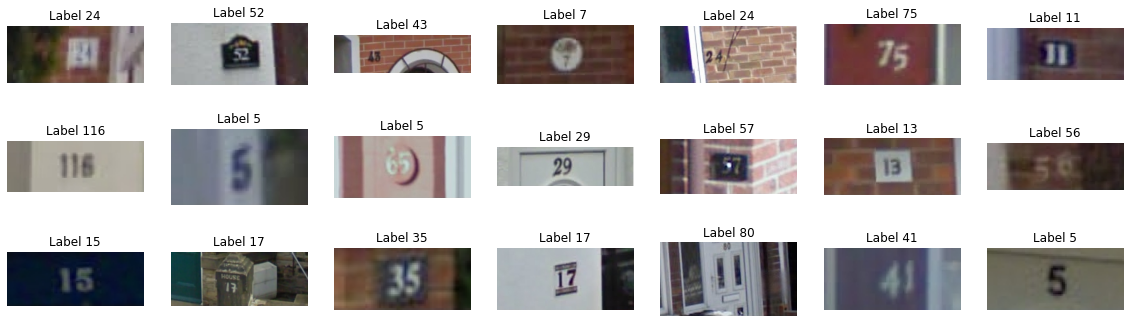

In [16]:
# Inspect the test data
plt.figure(figsize=(20, 10))
for i in range(21):
    plt.subplot(5, 7, i+1)

    img, label = real_data_list[i]

    plt.imshow(np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1))
    name = ""
    for i in range(len(label)):
      if label[i, 4].numpy() == 10:
        name += "0"
      else:
        name += str(int(label[i, 4].numpy()))

    plt.title("Label " + name)
    plt.axis('off')
plt.show()

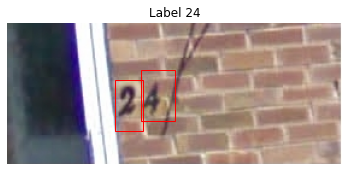

In [17]:
# Show a single image with a bounding boxes
img, label = real_data_list[4]

f, ax = plt.subplots()
ax.imshow(np.swapaxes(np.swapaxes(img.numpy(), 0, 2), 0, 1))
name = ""
for i in range(len(label)):
    if label[i,4].numpy() == 10:
        name += "0"
    else:
        name += str(int(label[i,4].numpy()))

    # add bounding box on image
    rect = patches.Rectangle((label[i,1], label[i,2]), label[i,3], label[i,0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Label " + name)
ax.axis('off')
plt.show()

## Train Model

In [18]:
use_saved = True

if use_saved:
    if os.path.isfile('./model.pickle'):
        import pickle
        model = pickle.load(open("./model.pickle", "rb+"))
    else: 
        print("ERROR: File not present.")
else:
    # Instantiate model
    model = m.PureCNN(config).to(device)

    # train model
    out_dict = m.train(model, config, project_name, train_loader, val_loader, n_train, n_val)

## Evaluate on Test Data

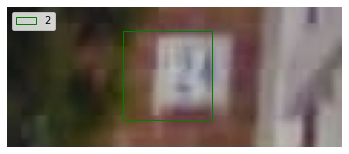

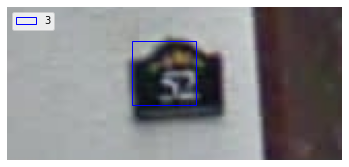

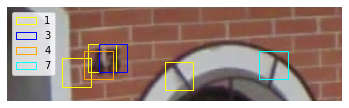

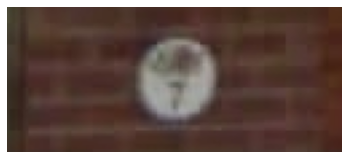

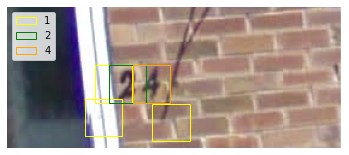

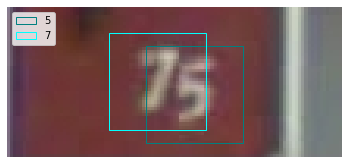

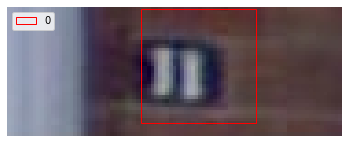

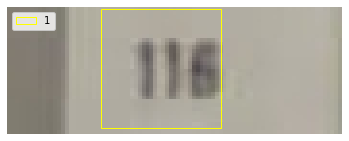

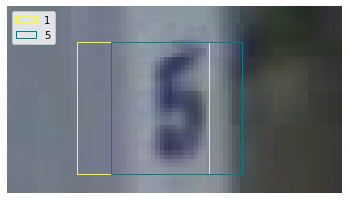

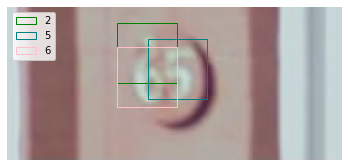

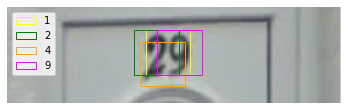

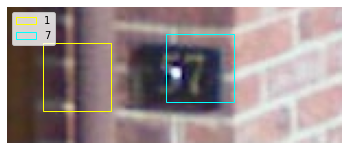

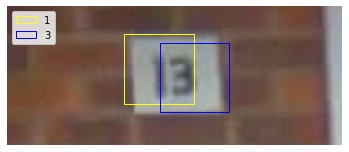

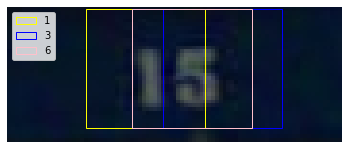

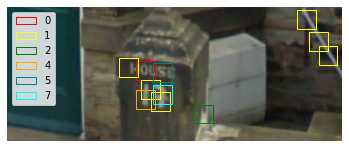

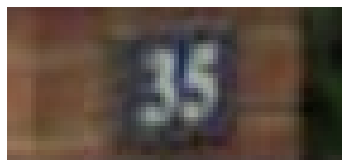

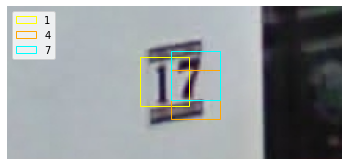

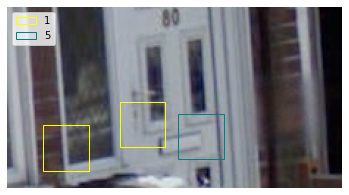

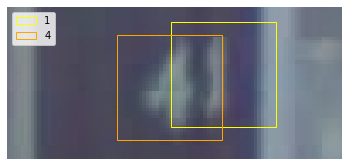

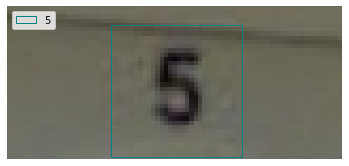

In [19]:
# do a single pass
model.eval()
N = 20
i = 0
for data, target in test_loader:
    if data.shape[1] >= 32 or data.shape[2] >= 32:
        with torch.no_grad():
            output = model(data.to(device))[0]
        output = F.softmax(output, dim=0)
        pred = output.argmax(0).cpu()
        img, lab = data[0].cpu(), target[0]
        boxes = h.non_maximum_supression(
            config, pred, output, 
            p_thresh=0.8, 
            iou_thresh=0.2
        )
        h.plt_bboxes(img, boxes, title='')
    if i >= N:
        break
    i += 1